<a href="https://colab.research.google.com/github/dinhtrang24/GCN-animation/blob/main/illustration_GCNs_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README

- If you want to see only animation, please look at the ANIMATION PART FIRST.

- Models with suffix '-std' mean these models running on z-score standardized data. Otherwise, they use unnormalized data

- If you want to play with more nodes, go to Data generation part, and reset no_nodes, then run everything again (you can quickly run everything by click to RUNTIME in the horizontal tab, then click "Restart and run all")


# Packages

In [1]:
#@title Packages
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn.dense.linear import Linear
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.utils import remove_self_loops
from torch_geometric.datasets import KarateClub
from torch_scatter import scatter_add
from torch_geometric.utils.convert import from_networkx
from torch.nn import Parameter


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines
from datetime import date, timedelta
import os
import random
import requests
import datetime
#%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.linalg import fractional_matrix_power
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import copy

import time
import timeit
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.6f' % x)

import warnings
warnings.filterwarnings("ignore")

In [4]:
import warnings; warnings.filterwarnings('ignore')
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder
import community
import itertools as IT
from scipy.special import softmax

In [5]:
#@title Earlystopping
#define Earlystopping as Pytorch does support it automatically
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [6]:
# Useful functions

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

def plot_cm(cm):
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Label 0', 'Label 1', 'Label 2',]
    make_confusion_matrix(cm,
                        group_names=labels,
                        categories=categories,
                        cmap=plt.cm.Blues,
                        figsize=(10,7))
    plt.show()



In [7]:
from scipy.stats import truncnorm

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Data generation

In [8]:
mean_gf1, sd_gf1, lower_gf1, upper_gf1 = 60, 20, 0, 100
mean_hf1, sd_hf1, lower_hf1, upper_hf1= 80, 20, 0, 100

mean_gf2, sd_gf2, lower_gf2, upper_gf2 = 25, 20, 0, 100
mean_hf2, sd_hf2, lower_hf2, upper_hf2= 35, 20, 0, 100

f10 = get_truncated_normal(mean=mean_gf1, sd=sd_gf1, low=lower_gf1, upp=upper_gf1)
f11 = get_truncated_normal(mean=mean_hf1, sd=sd_hf1, low=lower_hf1, upp=upper_hf1)
# f12 = get_truncated_normal(mean=mean_jf1, sd=sd_jf1, low=lower_jf1, upp=upper_jf1)
f20 = get_truncated_normal(mean=mean_gf2, sd=sd_gf2, low=lower_gf2, upp=upper_gf2)
f21 = get_truncated_normal(mean=mean_hf2, sd=sd_hf2, low=lower_hf2, upp=upper_hf2)
# f22 = get_truncated_normal(mean=mean_jf2, sd=sd_jf2, low=lower_jf2, upp=upper_jf2)


In [9]:
random.seed(42)
np.random.seed(42)
no_node=6
G=nx.gnp_random_graph(int(no_node/2),1)
H=nx.gnp_random_graph(int(no_node/2),1)
G_feat1=f10.rvs(len(G.nodes))
G_feat2=f20.rvs(len(G.nodes))
H_feat1=f11.rvs(len(H.nodes))
H_feat2=f21.rvs(len(H.nodes))
print(G_feat1, G_feat2)
print(H_feat1, H_feat2)
for node in G:
  G.nodes[node]['com']='g'
  G.nodes[node]['feat1']=G_feat1[node]
  G.nodes[node]['feat2']=G_feat2[node]
for node in H:
  H.nodes[node]['com']='h'
  H.nodes[node]['feat1']=H_feat1[node]
  H.nodes[node]['feat2']=H_feat2[node]

[53.19656464 89.39008443 71.40245423] [32.22304556 11.20471871 11.20334692]
[46.88735817 92.18115912 80.28865278] [46.61872966  3.87211333 72.78044486]


In [10]:
G.nodes(data=True)

NodeDataView({0: {'com': 'g', 'feat1': 53.196564638325945, 'feat2': 32.22304556051513}, 1: {'com': 'g', 'feat1': 89.39008442672643, 'feat2': 11.204718710725238}, 2: {'com': 'g', 'feat1': 71.40245422698906, 'feat2': 11.203346922041447}})

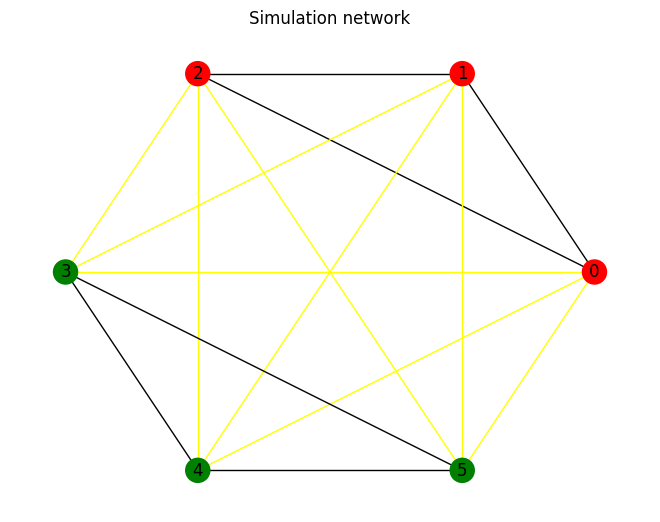

In [11]:
K=nx.union(G,H, rename=('G-','H-'))
for (u, v) in np.array(K.edges()):
  K.edges[u,v]['edge_color'] = 'black'
  K.edges[u,v]['edge_weight'] = 1
mapping = {list(sorted(K.nodes()))[i]:i for i in range(K.number_of_nodes())}
K = nx.relabel_nodes(K, mapping)
plt.figure(dpi=100)
pos = nx.circular_layout(K)
node_color = ['red' if K.nodes[v]['com'] == 'g' else 'g' for v in K]

# adding negative links
missing = [pair for pair in IT.combinations(K.nodes(), 2)
           if not K.has_edge(*pair)]
K.add_edges_from(missing, edge_color='yellow', edge_weight=-1)

edge_color = nx.get_edge_attributes(K,'edge_color').values()
nx.draw(K, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color)
plt.title('Simulation network')
plt.show()

{0: [53.196564638325945, 32.22304556051513], 1: [89.39008442672643, 11.204718710725238], 2: [71.40245422698906, 11.203346922041447], 3: [46.887358171694395, 46.618729659086334], 4: [92.18115911950504, 3.8721133292303413], 5: [80.28865278336868, 72.78044485944633]}


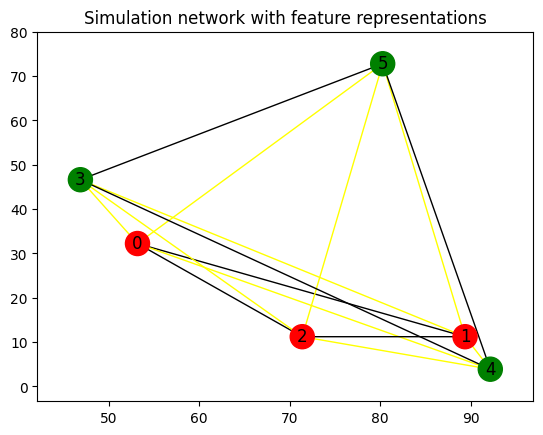

In [12]:
feature_representations = {node: [K.nodes[node]['feat1'], K.nodes[node]['feat2']] for node in K.nodes()}
print(feature_representations)
fig, ax = plt.subplots()
# plt.figure(dpi=100)
# Extract the feature representations
# Plot the embeddings
nx.draw(K, pos= feature_representations, with_labels=True, node_color=node_color, edge_color=edge_color, alpha=1,
        ax=ax)
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.title('Simulation network with feature representations')
plt.show()

In [13]:
K.nodes(data=True)

NodeDataView({0: {'com': 'g', 'feat1': 53.196564638325945, 'feat2': 32.22304556051513}, 1: {'com': 'g', 'feat1': 89.39008442672643, 'feat2': 11.204718710725238}, 2: {'com': 'g', 'feat1': 71.40245422698906, 'feat2': 11.203346922041447}, 3: {'com': 'h', 'feat1': 46.887358171694395, 'feat2': 46.618729659086334}, 4: {'com': 'h', 'feat1': 92.18115911950504, 'feat2': 3.8721133292303413}, 5: {'com': 'h', 'feat1': 80.28865278336868, 'feat2': 72.78044485944633}})

In [14]:
K.edges(data=True)

EdgeDataView([(0, 1, {'edge_color': 'black', 'edge_weight': 1}), (0, 2, {'edge_color': 'black', 'edge_weight': 1}), (0, 3, {'edge_color': 'yellow', 'edge_weight': -1}), (0, 4, {'edge_color': 'yellow', 'edge_weight': -1}), (0, 5, {'edge_color': 'yellow', 'edge_weight': -1}), (1, 2, {'edge_color': 'black', 'edge_weight': 1}), (1, 3, {'edge_color': 'yellow', 'edge_weight': -1}), (1, 4, {'edge_color': 'yellow', 'edge_weight': -1}), (1, 5, {'edge_color': 'yellow', 'edge_weight': -1}), (2, 3, {'edge_color': 'yellow', 'edge_weight': -1}), (2, 4, {'edge_color': 'yellow', 'edge_weight': -1}), (2, 5, {'edge_color': 'yellow', 'edge_weight': -1}), (3, 4, {'edge_color': 'black', 'edge_weight': 1}), (3, 5, {'edge_color': 'black', 'edge_weight': 1}), (4, 5, {'edge_color': 'black', 'edge_weight': 1})])

# Data

In [15]:
node0, node1=[], []
for node in K:
  if K.nodes[node]['com']=='g':
    node0.append(node)
  else:
    node1.append(node)
print('node0:', node0)
print('node1:', node1)

node0: [0, 1, 2]
node1: [3, 4, 5]


In [16]:
data = from_networkx(K)
print(data)

Data(edge_index=[2, 30], com=[6], feat1=[6], feat2=[6], edge_color=[30], edge_weight=[30], num_nodes=6)


In [17]:
feats=torch.cat((data.feat1.reshape(-1,1), data.feat2.reshape(-1,1)), 1)
feats=feats.to(torch.float32)
node_labels = [1 if K.nodes[v]['com'] == 'h' else 0 for v in K]
node_labels = torch.LongTensor(node_labels)

In [18]:
random.seed(42)
train_ratio = 1/3
val_ratio=1/3
train0=random.sample(node0, int(len(node0)*train_ratio))
train1=random.sample(node1, int(len(node1)*train_ratio))
train_nodes=train0+train1
val0=random.sample(set(node0)-set(train0), int(len(node0)*val_ratio))
val1=random.sample(set(node1)-set(train1), int(len(node1)*val_ratio))
val_nodes=val0+val1
test_nodes= list(set(list(K.nodes()))- set(val_nodes)- set(train_nodes))
train_mask = torch.zeros(K.number_of_nodes(), dtype=torch.bool)
val_mask = torch.zeros(K.number_of_nodes(), dtype=torch.bool)
test_mask = torch.zeros(K.number_of_nodes(), dtype=torch.bool)
for i in train_nodes:
    train_mask[i] = True
for i in val_nodes:
    val_mask[i] = True
for i in test_nodes:
    test_mask[i] = True
print(train_mask)
print(val_mask)
print(test_mask)

tensor([False, False,  True,  True, False, False])
tensor([ True, False, False, False, False,  True])
tensor([False,  True, False, False,  True, False])


In [19]:
edge_type=torch.zeros(data.edge_index.shape[1])
edge_type[np.where(data.edge_weight<0)]=1
num_relations=np.unique(edge_type).shape[0]
data_new = Data(x=feats, edge_index=data.edge_index,y=node_labels, edge_weight=data.edge_weight.to(torch.float32),
               train_mask=train_mask, val_mask=val_mask, test_mask=test_mask,
               edge_type=edge_type, num_relations=num_relations)
print(f'Graph: {data_new}')
print(f'Edges are directed: {data_new.is_directed()}')
print(f'Graph has isolated nodes: {data_new.has_isolated_nodes()}')
print(f'Graph has loops: {data_new.has_self_loops()}')
print('Number of positive edges:', sum(data_new.edge_weight>0) )
print('Number of negative edges:', sum(data_new.edge_weight<0) )
print('Positive degree:', sum(data_new.edge_weight>0)/data_new.y.shape[0] )
print('Negative degree:', sum(data_new.edge_weight<0)/data_new.y.shape[0] )

Graph: Data(x=[6, 2], edge_index=[2, 30], y=[6], edge_weight=[30], train_mask=[6], val_mask=[6], test_mask=[6], edge_type=[30], num_relations=2)
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Number of positive edges: tensor(12)
Number of negative edges: tensor(18)
Positive degree: tensor(2.)
Negative degree: tensor(3.)


In [20]:
edge_type=torch.zeros(data_new.edge_index[:,np.where(data_new.edge_weight>0)[0]].shape[1])
num_relations=np.unique(edge_type).shape[0]

data_pos= Data(x=data_new.x,edge_index=data_new.edge_index[:,np.where(data_new.edge_weight>0)[0]],
               y=data_new.y,edge_weight=data_new.edge_weight[np.where(data_new.edge_weight>0)[0]],
               train_mask=data_new.train_mask, val_mask=data_new.val_mask, test_mask=data_new.test_mask,
               edge_type=edge_type, num_relations=num_relations)
print(f'Graph: {data_pos}')
print(f'Edges are directed: {data_pos.is_directed()}')
print(f'Graph has isolated nodes: {data_pos.has_isolated_nodes()}')
print(f'Graph has loops: {data_pos.has_self_loops()}')
print(f'Number of relations: {data_pos.num_relations}')

Graph: Data(x=[6, 2], edge_index=[2, 12], y=[6], edge_weight=[12], train_mask=[6], val_mask=[6], test_mask=[6], edge_type=[12], num_relations=1)
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Number of relations: 1


In [21]:
edge_type=torch.zeros(data_new.edge_index[:,np.where(data_new.edge_weight<0)[0]].shape[1])
num_relations=np.unique(edge_type).shape[0]

data_neg= Data(x=data_new.x,edge_index=data_new.edge_index[:,np.where(data_new.edge_weight<0)[0]],
               y=data_new.y,edge_weight=data_new.edge_weight[np.where(data_new.edge_weight<0)[0]],
               train_mask=data_new.train_mask, val_mask=data_new.val_mask, test_mask=data_new.test_mask,
               edge_type=edge_type, num_relations=num_relations)
print(f'Graph: {data_neg}')
print(f'Edges are directed: {data_neg.is_directed()}')
print(f'Graph has isolated nodes: {data_neg.has_isolated_nodes()}')
print(f'Graph has loops: {data_neg.has_self_loops()}')
print(f'Number of relations: {data_neg.num_relations}')

Graph: Data(x=[6, 2], edge_index=[2, 18], y=[6], edge_weight=[18], train_mask=[6], val_mask=[6], test_mask=[6], edge_type=[18], num_relations=1)
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Number of relations: 1


In [22]:
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(feats[train_mask])
feats_standard = np.zeros(feats.shape)
feats_standard[train_mask]=standard_scaler.transform(feats[train_mask])
feats_standard[val_mask]=standard_scaler.transform(feats[val_mask])
feats_standard[test_mask]=standard_scaler.transform(feats[test_mask])
feats_standard=torch.from_numpy(feats_standard.astype(np.float32))

In [23]:
edge_type=torch.zeros(data_new.edge_index.shape[1])
edge_type[np.where(data_new.edge_weight<0)]=1
num_relations=np.unique(edge_type).shape[0]
data_standard = Data(x=feats_standard, edge_index=data_new.edge_index,y=data_new.y,edge_weight=data_new.edge_weight,
               train_mask=train_mask, val_mask=val_mask, test_mask=test_mask,
               edge_type=edge_type, num_relations=num_relations)
print(f'Graph: {data_standard}')
print(f'Edges are directed: {data_standard.is_directed()}')
print(f'Graph has isolated nodes: {data_standard.has_isolated_nodes()}')
print(f'Graph has loops: {data_standard.has_self_loops()}')

Graph: Data(x=[6, 2], edge_index=[2, 30], y=[6], edge_weight=[30], train_mask=[6], val_mask=[6], test_mask=[6], edge_type=[30], num_relations=2)
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [24]:
edge_type=torch.zeros(data_new.edge_index[:,np.where(data_new.edge_weight>0)[0]].shape[1])
num_relations=np.unique(edge_type).shape[0]

data_pos_standard= Data(x=feats_standard, edge_index=data_new.edge_index[:,np.where(data_new.edge_weight>0)[0]],y=data_new.y,edge_weight=data_new.edge_weight[np.where(data_new.edge_weight>0)[0]],
               train_mask=data_new.train_mask, val_mask=data_new.val_mask, test_mask=data_new.test_mask,
               edge_type=edge_type, num_relations=num_relations)
print(f'Graph: {data_pos_standard}')
print(f'Edges are directed: {data_pos_standard.is_directed()}')
print(f'Graph has isolated nodes: {data_pos_standard.has_isolated_nodes()}')
print(f'Graph has loops: {data_pos_standard.has_self_loops()}')
print(f'Number of relations: {data_pos_standard.num_relations}')

Graph: Data(x=[6, 2], edge_index=[2, 12], y=[6], edge_weight=[12], train_mask=[6], val_mask=[6], test_mask=[6], edge_type=[12], num_relations=1)
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Number of relations: 1


# ANIM CODE

In [25]:
# def anim_plot(model_name, embed, acc, G):
#   fig= plt.figure(dpi=150)
#   ax = fig.subplots()

#   def draw_embeddings(i):
#       output = embed[0][i].detach().numpy()
#       feature_representations = {node: np.round(np.array(output),4)[node] for node in G.nodes()}
#       # print(feature_representations)

#       ax.cla()
#       # ax.axis('off')
#       ax.set_title(str(model_name).upper()+' embeddings for Epoch: %d' % i +f'| Acc: {acc[0][i]*100:.2f}%',)
#       nx.draw_networkx(G, pos= feature_representations, node_color=node_color, edge_color=edge_color, alpha=0.5,
#               with_labels=True, node_size=300, ax=ax)
#       ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#       ax.set_xlim([min(torch.cat(embed[0], dim=0).detach().numpy()[:,0])-2, max(torch.cat(embed[0], dim=0).detach().numpy()[:,0])+2])
#       ax.set_ylim([min(torch.cat(embed[0], dim=0).detach().numpy()[:,1])-2, max(torch.cat(embed[0], dim=0).detach().numpy()[:,1])+2])
#       plt.close()
#   plt.close()
#   anim = animation.FuncAnimation(fig, draw_embeddings,  frames=len(embed[0]),interval=100)
#   html = HTML(anim.to_html5_video())
#   display(html)

In [26]:
node_shapes=[]
for node in K:
    if node in train_nodes:
        node_shapes.append('o')
    elif node in val_nodes:
        node_shapes.append('v')
    elif node in test_nodes:
        node_shapes.append('s')
for i,node in enumerate(K.nodes()):
        K.nodes[node]['shape'] = node_shapes[i]
        K.nodes[node]['color'] = node_color[i]

def anim_plot(model_name, embed, acc, G):
  fig= plt.figure(dpi=150)
  ax = fig.subplots()

  def draw_embeddings(i):
      output = embed[0][i].detach().numpy()
      feature_representations = {node: np.round(np.array(output),4)[node] for node in G.nodes()}
      # print(feature_representations)

      ax.cla()
      # ax.axis('off')
      ax.set_title(str(model_name).upper()+' embeddings for Epoch: %d' % i +f'| Acc: {acc[0][i]*100:.2f}%',)
      nx.draw_networkx_edges(G,pos= feature_representations, edge_color=edge_color, alpha=0.5, ax=ax) # draw edges
      nx.draw_networkx_labels(G,pos= feature_representations, ax=ax, alpha=0.5) # draw node labels
      for shape in set(node_shapes):
        # the nodes with the desired shapes
        node_list = [node for node in G.nodes() if G.nodes[node]['shape'] == shape]
        nx.draw_networkx_nodes(G,pos= feature_representations,
                              nodelist = node_list,
                              node_color= [G.nodes[node]['color'] for node in node_list],
                              node_shape = shape,
                              alpha=0.5,  node_size=300, ax=ax)
      # nx.draw_networkx(K, pos= feature_representations, node_color=node_color, edge_color=edge_color, alpha=0.5,
      #         with_labels=True, node_size=300, ax=ax)
      ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
      ax.set_xlim([min(torch.cat(embed[0], dim=0).detach().numpy()[:,0])-2, max(torch.cat(embed[0], dim=0).detach().numpy()[:,0])+2])
      ax.set_ylim([min(torch.cat(embed[0], dim=0).detach().numpy()[:,1])-2, max(torch.cat(embed[0], dim=0).detach().numpy()[:,1])+2])
      plt.close()
  plt.close()
  anim = animation.FuncAnimation(fig, draw_embeddings,  frames=len(embed[0]),interval=100)
  html = HTML(anim.to_html5_video())
  display(html)

# GCN

In [27]:
class GCNConv(MessagePassing):
        def __init__(self, in_channels, out_channels):
            super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
            self.lin = Linear(in_channels, out_channels, bias=False)
            self.bias = Parameter(torch.Tensor(out_channels))

            self.reset_parameters()

        def reset_parameters(self):
            self.lin.reset_parameters()
            self.bias.data.zero_()

        def forward(self, x, edge_index, edge_weight):
            # Step 1: Add self-loops to the adjacency matrix.
            edge_index_self_loop, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            edge_weight_self_loop = torch.cat((edge_weight, torch.ones(x.size(0))), dim=0)

            # Step 2: Linearly transform node feature matrix.
            x = self.lin(x)

            # Step 3: Compute normalization.
            row, col = edge_index_self_loop
            deg = scatter_add(torch.abs(edge_weight_self_loop), col, dim=0, dim_size=x.size(0))
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * torch.abs(edge_weight_self_loop) * deg_inv_sqrt[col]

            # Step 4-5: Start propagating messages.
            out= self.propagate(edge_index_self_loop, x=x, norm=norm, edge_weight_self_loop=edge_weight_self_loop)
            out += self.bias

            return out
        def message(self, x_i, x_j, norm, edge_weight_self_loop):
            # sign=torch.sign(edge_weight_self_loop).view(-1,1)
            # x_j = (sign*x_j + x_i*(1 - sign))

            # Step 4: Normalize node features.
            return (norm.view(-1, 1) * x_j)

In [28]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # torch.manual_seed(12345)
        self.gcn = GCNConv(data_new.x.shape[1], 16)
        self.out = GCNConv(16, len(np.unique(data_new.y)))

    def forward(self, x, edge_index, edge_weight):
        h = self.gcn(x, edge_index, edge_weight).relu()
        z = self.out(h, edge_index, edge_weight)
        return h, z

In [29]:
def gcn_function(data, t, p, e):
    embeddings_ls, losses_ls, accuracies_ls, outputs_ls = [],[],[],[]
    val_losses_ls=[]
    test_acc_ls, test_f1_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls  = [],[],[],[],[]
    for i in range(t):
        print('RUN:', i)
        model = GCN()

        # Data for animations
        embeddings = []
        losses = []
        accuracies = []
        outputs = []

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # Define optimizer.
        es = EarlyStopping(patience=p)

        def train(model):
            model.train()   # setting the model to train mode
            optimizer.zero_grad()  # Clear gradients.
            h,out = model(data.x, data.edge_index, torch.abs(data.edge_weight))  # Perform a single forward pass.
            loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            return loss,h,out

        def val (model):
            with torch.no_grad():
                model.eval()
                h,out = model(data.x, data.edge_index, torch.abs(data.edge_weight))  # Perform a single forward pass.
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
                return val_loss

        def test(model):
            with torch.no_grad():   #Turn off gradients.
                model.eval()   # set model to evaluation mode
                h,out = model(data.x, data.edge_index, torch.abs(data.edge_weight))
                pred = out.argmax(dim=1)  # Use the class with highest probability.
                test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
                test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
                test_f1_micro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='micro')
                test_f1_macro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
                test_f1_weighted = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
                cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
                return test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm

        losses, val_losses = [], []
        min_val_loss = 1000000
        for epoch in range(1, e):
            loss,h,out = train(model)
            val_loss = val(model)
            test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm = test(model)
            if min_val_loss > val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
            print('Epoch:', epoch, ' Train loss:', loss, ' Val loss:', val_loss, 'Min Val loss:', min_val_loss, 'test acc:', test_acc)
            if es.step(val_loss):
                break

            embeddings.append(h)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(test_acc)
            outputs.append(out)
        best_test_acc, best_test_f1_micro, best_test_f1_macro, best_test_f1_weighted, best_cm = test(best_model)

        test_acc_ls.append(best_test_acc)
        test_f1_micro_ls.append(best_test_f1_micro)
        test_f1_macro_ls.append(best_test_f1_macro)
        test_f1_weighted_ls.append(best_test_f1_weighted)
        plot_cm(best_cm)
        print(f'Test Accuracy: {best_test_acc:.5f}')
        model.eval()   # set model to evaluation mode
        embeddings_ls.append(embeddings)
        accuracies_ls.append(accuracies)
        losses_ls.append(losses)
        outputs_ls.append(outputs)
        val_losses_ls.append(val_losses)
    # return test_acc_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls,
    return accuracies_ls, embeddings_ls, outputs_ls, losses_ls, val_losses_ls



# LAP-GCN

In [30]:
class GCNConv_lap(MessagePassing):
        def __init__(self, in_channels, out_channels):
            super(GCNConv_lap, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
            self.lin = Linear(in_channels, out_channels, bias=False)
            self.bias = Parameter(torch.Tensor(out_channels))

            self.reset_parameters()

        def reset_parameters(self):
            self.lin.reset_parameters()
            self.bias.data.zero_()

        def forward(self, x, edge_index, edge_weight):
            # Step 1: Add self-loops to the adjacency matrix.
            edge_index_self_loop, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            edge_weight_self_loop = torch.cat((edge_weight, torch.ones(x.size(0))), dim=0)

            # Step 2: Linearly transform node feature matrix.
            x = self.lin(x)

            # Step 3: Compute normalization.
            row, col = edge_index_self_loop
            deg = scatter_add(torch.abs(edge_weight_self_loop), col, dim=0, dim_size=x.size(0))
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * torch.abs(edge_weight_self_loop) * deg_inv_sqrt[col]

            # Step 4-5: Start propagating messages.
            out= self.propagate(edge_index_self_loop, x=x, norm=norm, edge_weight_self_loop=edge_weight_self_loop)
            out += self.bias

            return out
        def message(self, x_i, x_j, norm, edge_weight_self_loop):
            sign=torch.sign(edge_weight_self_loop).view(-1,1)
            x_j = (sign*x_j)

            # Step 4: Normalize node features.
            return (norm.view(-1, 1) * x_j)

In [31]:
class GCN_lap(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # torch.manual_seed(12345)
        self.gcn = GCNConv_lap(data_new.x.shape[1], 16)
        self.out = GCNConv_lap(16, len(np.unique(data_new.y)))

    def forward(self, x, edge_index, edge_weight):
        h = self.gcn(x, edge_index, edge_weight).relu()
        z = self.out(h, edge_index, edge_weight)
        return h, z

In [32]:
def gcnlap_function(data, t, p, e):
    embeddings_ls, losses_ls, accuracies_ls, outputs_ls = [],[],[],[]
    val_losses_ls=[]
    test_acc_ls, test_f1_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls  = [],[],[],[],[]
    for i in range(t):
        print('RUN:', i)
        model = GCN_lap()

        # Data for animations
        embeddings = []
        losses = []
        accuracies = []
        outputs = []

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # Define optimizer.
        es = EarlyStopping(patience=p)

        def train(model):
            model.train()   # setting the model to train mode
            optimizer.zero_grad()  # Clear gradients.
            h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
            loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            return loss,h,out

        def val (model):
            with torch.no_grad():
                model.eval()
                h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
                return val_loss

        def test(model):
            with torch.no_grad():   #Turn off gradients.
                model.eval()   # set model to evaluation mode
                h,out = model(data.x, data.edge_index, data.edge_weight)
                pred = out.argmax(dim=1)  # Use the class with highest probability.
                test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
                test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
                test_f1_micro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='micro')
                test_f1_macro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
                test_f1_weighted = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
                cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
                return test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm

        losses, val_losses = [], []
        min_val_loss = 1000000
        for epoch in range(1, e):
            loss,h,out = train(model)
            val_loss = val(model)
            test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm = test(model)
            if min_val_loss > val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
            print('Epoch:', epoch, ' Train loss:', loss, ' Val loss:', val_loss, 'Min Val loss:', min_val_loss, 'test acc:', test_acc)
            if es.step(val_loss):
                break

            embeddings.append(h)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(test_acc)
            outputs.append(out)
        best_test_acc, best_test_f1_micro, best_test_f1_macro, best_test_f1_weighted, best_cm = test(best_model)

        test_acc_ls.append(best_test_acc)
        test_f1_micro_ls.append(best_test_f1_micro)
        test_f1_macro_ls.append(best_test_f1_macro)
        test_f1_weighted_ls.append(best_test_f1_weighted)
        plot_cm(best_cm)
        print(f'Test Accuracy: {best_test_acc:.5f}')
        model.eval()   # set model to evaluation mode
        embeddings_ls.append(embeddings)
        accuracies_ls.append(accuracies)
        losses_ls.append(losses)
        outputs_ls.append(outputs)
        val_losses_ls.append(val_losses)
    # return test_acc_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls,
    return accuracies_ls, embeddings_ls, outputs_ls, losses_ls, val_losses_ls



# Diff-GCN

In [33]:
class GCNConv_diff(MessagePassing):
        def __init__(self, in_channels, out_channels):
            super(GCNConv_diff, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
            self.lin = Linear(in_channels, out_channels, bias=False)
            self.bias = Parameter(torch.Tensor(out_channels))

            self.reset_parameters()

        def reset_parameters(self):
            self.lin.reset_parameters()
            self.bias.data.zero_()

        def forward(self, x, edge_index, edge_weight):
            # Step 1: Add self-loops to the adjacency matrix.
            edge_index_self_loop, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            edge_weight_self_loop = torch.cat((edge_weight, torch.ones(x.size(0))), dim=0)

            # Step 2: Linearly transform node feature matrix.
            x = self.lin(x)

            # Step 3: Compute normalization.
            row, col = edge_index_self_loop
            deg = scatter_add(torch.abs(edge_weight_self_loop), col, dim=0, dim_size=x.size(0))
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * torch.abs(edge_weight_self_loop) * deg_inv_sqrt[col]

            # Step 4-5: Start propagating messages.
            out= self.propagate(edge_index_self_loop, x=x, norm=norm, edge_weight_self_loop=edge_weight_self_loop)
            out += self.bias

            return out
        def message(self, x_i, x_j, norm, edge_weight_self_loop):
            sign=torch.sign(edge_weight_self_loop).view(-1,1)
            x_j = (sign*x_j + x_i*(1 - sign))

            # Step 4: Normalize node features.
            return (norm.view(-1, 1) * x_j)

In [34]:
class GCN_diff(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # torch.manual_seed(12345)
        self.gcn = GCNConv_diff(data_new.x.shape[1], 16)
        self.out = GCNConv_diff(16, len(np.unique(data_new.y)))

    def forward(self, x, edge_index, edge_weight):
        h = self.gcn(x, edge_index, edge_weight).relu()
        z = self.out(h, edge_index, edge_weight)
        return h, z

In [35]:
def gcndiff_function(data, t, p, e):
    embeddings_ls, losses_ls, accuracies_ls, outputs_ls = [],[],[],[]
    val_losses_ls=[]
    test_acc_ls, test_f1_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls  = [],[],[],[],[]
    for i in range(t):
        print('RUN:', i)
        model = GCN_diff()

        # Data for animations
        embeddings = []
        losses = []
        accuracies = []
        outputs = []

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # Define optimizer.
        es = EarlyStopping(patience=p)

        def train(model):
            model.train()   # setting the model to train mode
            optimizer.zero_grad()  # Clear gradients.
            h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
            loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            return loss,h,out

        def val (model):
            with torch.no_grad():
                model.eval()
                h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
                return val_loss

        def test(model):
            with torch.no_grad():   #Turn off gradients.
                model.eval()   # set model to evaluation mode
                h,out = model(data.x, data.edge_index, data.edge_weight)
                pred = out.argmax(dim=1)  # Use the class with highest probability.
                test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
                test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
                test_f1_micro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='micro')
                test_f1_macro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
                test_f1_weighted = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
                cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
                return test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm

        losses, val_losses = [], []
        min_val_loss = 1000000
        for epoch in range(1, e):
            loss,h,out = train(model)
            val_loss = val(model)
            test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm = test(model)
            if min_val_loss > val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
            print('Epoch:', epoch, ' Train loss:', loss, ' Val loss:', val_loss, 'Min Val loss:', min_val_loss, 'test acc:', test_acc)
            if es.step(val_loss):
                break

            embeddings.append(h)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(test_acc)
            outputs.append(out)
        best_test_acc, best_test_f1_micro, best_test_f1_macro, best_test_f1_weighted, best_cm = test(best_model)

        test_acc_ls.append(best_test_acc)
        test_f1_micro_ls.append(best_test_f1_micro)
        test_f1_macro_ls.append(best_test_f1_macro)
        test_f1_weighted_ls.append(best_test_f1_weighted)
        plot_cm(best_cm)
        print(f'Test Accuracy: {best_test_acc:.5f}')
        model.eval()   # set model to evaluation mode
        embeddings_ls.append(embeddings)
        accuracies_ls.append(accuracies)
        losses_ls.append(losses)
        outputs_ls.append(outputs)
        val_losses_ls.append(val_losses)
    # return test_acc_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls,
    return accuracies_ls, embeddings_ls, outputs_ls, losses_ls, val_losses_ls



# NLINEAR-GCN

In [36]:
def feat_calculation(edge_index, feature):

    feat_diff = feature[edge_index[0]]-feature[edge_index[1]]
    feat_dist = torch.norm(feature[edge_index[0]]-feature[edge_index[1]],dim=1)

    return feat_diff, feat_dist
class GCNConv_nonlinear(MessagePassing):
        def __init__(self, in_channels, out_channels):
            super(GCNConv_nonlinear, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
            self.lin = Linear(in_channels, out_channels, bias=False, weight_initializer='glorot')
            self.scalar1 = torch.nn.Linear(1, 1, bias=False)
            self.in_channels=in_channels
            self.bias = Parameter(torch.Tensor(out_channels))

            self.reset_parameters()

        def reset_parameters(self):
            self.lin.reset_parameters()
            self.bias.data.zero_()

        def forward(self, x, edge_index, edge_weight):

            # Step 1: Add self-loops to the adjacency matrix.
            edge_index_self_loop, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            edge_weight_self_loop = torch.cat((edge_weight, torch.ones(x.size(0))), dim=0)

            feat_diff, feat_dist =  feat_calculation(edge_index, x)
            zero_vector = torch.zeros(self.in_channels)
            feat_diff = torch.cat((feat_diff, zero_vector.repeat(x.size(0),1)))
            feat_dist = torch.cat((feat_dist, torch.zeros(x.size(0))))

            # Step 3: Compute normalization.
            row, col = edge_index_self_loop
            deg = scatter_add(np.abs(edge_weight_self_loop), col, dim=0, dim_size=x.size(0))
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * np.abs(edge_weight_self_loop) * deg_inv_sqrt[col]

            # Step 4-5: Start propagating messages.
            out= self.propagate(edge_index_self_loop, x=x, norm=norm, edge_weight_self_loop=edge_weight_self_loop, edge_index_self_loop=edge_index_self_loop, feat_diff=feat_diff, feat_dist=feat_dist)
            out += self.bias

            return out

        def message(self, x_i, x_j, norm, edge_weight_self_loop, edge_index_self_loop, feat_diff, feat_dist):

            #find the position where feat_dist!=0 and feat_dist=0
            x_j1=torch.zeros(x_j.shape)
            x_j2=torch.zeros(x_j.shape)
            diff_location=np.where(feat_dist!=0)
            #reshape diff_location
            diff_loc = np.array(np.repeat(diff_location[0], self.in_channels))
            diff_loc = np.array((diff_loc, np.tile(np.arange(self.in_channels), len(diff_location[0]))))

            same_location=np.where(feat_dist==0)
            #reshape same_location
            same_loc = np.repeat(same_location[0], self.in_channels)
            same_loc = np.array((same_loc, np.tile(np.arange(self.in_channels), len(same_location[0]))))

            sign=torch.sign(edge_weight_self_loop).view(-1,1)

            x_j1[diff_loc]=x_i[diff_loc]+ sign[diff_loc[0]].view(-1)*(feat_diff[diff_loc]/feat_dist[diff_loc[0]])*torch.pow(feat_dist[diff_loc[0]]+(1-sign[diff_loc[0]].view(-1))/2,sign[diff_loc[0]].view(-1))

            #if x_i=x_j: it can be self-loop connections, and different nodes having same feature values
            x_j2[same_loc]=x_j[same_loc]

            #final x_j will be the sum of x_j1 and x_j2
            x_j=x_j1+x_j2

            #we multiply x_j with the trainable weights which correspond to hidden nodes
            x_j = self.lin(x_j)

            return norm.view(-1, 1) * x_j

In [37]:
class GCN_nlinear(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # torch.manual_seed(12345)
        self.gcn = GCNConv_nonlinear(data_new.x.shape[1], 16)
        self.out = GCNConv_nonlinear(16, len(np.unique(data_new.y)))

    def forward(self, x, edge_index, edge_weight):
        h = self.gcn(x, edge_index, edge_weight).relu()
        z = self.out(h, edge_index, edge_weight)
        return h, z

In [38]:
def gcnnlinear_function(data, t, p, e):
    embeddings_ls, losses_ls, accuracies_ls, outputs_ls = [],[],[],[]
    val_losses_ls=[]
    test_acc_ls, test_f1_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls  = [],[],[],[],[]
    for i in range(t):
        print('RUN:', i)
        model = GCN_nlinear()

        # Data for animations
        embeddings = []
        losses = []
        accuracies = []
        outputs = []

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # Define optimizer.
        es = EarlyStopping(patience=p)

        def train(model):
            model.train()   # setting the model to train mode
            optimizer.zero_grad()  # Clear gradients.
            h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
            loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            return loss,h,out

        def val (model):
            with torch.no_grad():
                model.eval()
                h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
                return val_loss

        def test(model):
            with torch.no_grad():   #Turn off gradients.
                model.eval()   # set model to evaluation mode
                h,out = model(data.x, data.edge_index, data.edge_weight)
                pred = out.argmax(dim=1)  # Use the class with highest probability.
                test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
                test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
                test_f1_micro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='micro')
                test_f1_macro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
                test_f1_weighted = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
                cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
                return test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm

        losses, val_losses = [], []
        min_val_loss = 1000000
        for epoch in range(1, e):
            loss,h,out = train(model)
            val_loss = val(model)
            test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm = test(model)
            if min_val_loss > val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
            print('Epoch:', epoch, ' Train loss:', loss, ' Val loss:', val_loss, 'Min Val loss:', min_val_loss, 'test acc:', test_acc)
            if es.step(val_loss):
                break

            embeddings.append(h)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(test_acc)
            outputs.append(out)
        best_test_acc, best_test_f1_micro, best_test_f1_macro, best_test_f1_weighted, best_cm = test(best_model)

        test_acc_ls.append(best_test_acc)
        test_f1_micro_ls.append(best_test_f1_micro)
        test_f1_macro_ls.append(best_test_f1_macro)
        test_f1_weighted_ls.append(best_test_f1_weighted)
        plot_cm(best_cm)
        print(f'Test Accuracy: {best_test_acc:.5f}')
        model.eval()   # set model to evaluation mode
        embeddings_ls.append(embeddings)
        accuracies_ls.append(accuracies)
        losses_ls.append(losses)
        outputs_ls.append(outputs)
        val_losses_ls.append(val_losses)
    # return test_acc_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls,
    return accuracies_ls, embeddings_ls, outputs_ls, losses_ls, val_losses_ls



# R-GCN

In [39]:
from torch_geometric.nn import FastRGCNConv, RGCNConv
class RGCN_Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn1 = RGCNConv(data_new.x.shape[1], 16, data_new.num_relations)
        self.out = RGCNConv(16, len(np.unique(data_new.y)), data_new.num_relations)


    def forward(self, x, edge_index, edge_type):
        h = F.relu(self.gcn1(x, edge_index, edge_type))
        z = self.out(h, edge_index, edge_type)
        return h,z

In [40]:
def rgcn_net_function(data, t, p, e):
    embeddings_ls, losses_ls, accuracies_ls, outputs_ls = [],[],[],[]
    val_losses_ls=[]
    test_acc_ls, test_f1_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls  = [],[],[],[],[]
    for i in range(t):
        print('RUN:', i)
        model = RGCN_Net()

        # Data for animations
        embeddings = []
        losses = []
        accuracies = []
        outputs = []

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # Define optimizer.
        es = EarlyStopping(patience=p)

        def train(model):
            model.train()   # setting the model to train mode
            optimizer.zero_grad()  # Clear gradients.
            h,out = model(data.x, data.edge_index, data.edge_type)  # Perform a single forward pass.
            loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.

            torch.nn.utils.clip_grad_norm(model.parameters(), 1.)
            optimizer.step()  # Update parameters based on gradients.
            return loss,h,out

        def val(model):
            with torch.no_grad():
                model.eval()
                h,out = model(data.x,data.edge_index, data.edge_type)  # Perform a single forward pass.
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
                return val_loss

        def test(model):
            with torch.no_grad():   #Turn off gradients.
                model.eval()   # set model to evaluation mode
                h,out = model(data.x,data.edge_index, data.edge_type)
                pred = out.argmax(dim=1)  # Use the class with highest probability.
                test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
                test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
                test_f1_micro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='micro')
                test_f1_macro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
                test_f1_weighted = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
                cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
                return test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm

        losses, val_losses = [], []
        min_val_loss = 1000000
        for epoch in range(1, e):
            loss,h,out = train(model)
            val_loss = val(model)
            test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm = test(model)

            if min_val_loss > val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)

            print('Epoch:', epoch, ' Train loss:', loss, ' Val loss:', val_loss, 'Min Val loss:', min_val_loss, 'test acc:', test_acc)
            if es.step(val_loss):
                break
            embeddings.append(h)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(test_acc)
#             outputs.append(out.argmax(dim=1))
            outputs.append(out)
        best_test_acc, best_test_f1_micro, best_test_f1_macro, best_test_f1_weighted, best_cm = test(best_model)

        test_acc_ls.append(best_test_acc)
        test_f1_micro_ls.append(best_test_f1_micro)
        test_f1_macro_ls.append(best_test_f1_macro)
        test_f1_weighted_ls.append(best_test_f1_weighted)
        plot_cm(best_cm)
        print(f'Test Accuracy: {test_acc:.5f}')
        model.eval()   # set model to evaluation mode

        embeddings_ls.append(embeddings)
        accuracies_ls.append(accuracies)
        losses_ls.append(losses)
        outputs_ls.append(outputs)
        val_losses_ls.append(val_losses)
    # return test_acc_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls, losses_ls, val_losses_ls, accuracies_ls, outputs_ls
    return accuracies_ls, embeddings_ls, outputs_ls, losses_ls, val_losses_ls



# GCN-repel

In [41]:
class GCNConv_diff_repel(MessagePassing):
        def __init__(self, in_channels, out_channels):
            super(GCNConv_diff_repel, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
            self.lin = Linear(in_channels, out_channels, bias=False, weight_initializer='glorot')
            self.control1 = Linear(2, 1, bias=False, weight_initializer='glorot')
#             self.control2 = Linear(1, 1, bias=False, weight_initializer='glorot')
#             self.control3 = Linear(1, 1, bias=False, weight_initializer='glorot')
            self.bias = Parameter(torch.Tensor(out_channels))

            self.reset_parameters()

        def reset_parameters(self):
            self.lin.reset_parameters()
            self.bias.data.zero_()
#             nn.init.uniform_(self.control1.weight, a=0, b=1)
#             nn.init.zeros_(self.control1.weight)

        def forward(self, x, edge_index, edge_weight):
            # Step 1: Add self-loops to the adjacency matrix.
            edge_index_self_loop, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            edge_weight_self_loop = torch.cat((edge_weight, torch.ones(x.size(0))), dim=0)

#             x = self.lin(x)
            pos_idx=torch.where(edge_weight_self_loop>0)[0]
            neg_idx=torch.where(edge_weight_self_loop<0)[0]
#             self_idx=torch.tensor(range(len(edge_weight_self_loop))[-x.size(0):])
            # Step 3: Compute normalization.
            row_pos, col_pos = edge_index_self_loop[:, pos_idx]
            deg_pos = scatter_add(torch.abs(edge_weight_self_loop[pos_idx]), col_pos, dim=0, dim_size=x.size(0))
            deg_inv_sqrt_pos = deg_pos.pow(-0.5)
            norm_pos = deg_inv_sqrt_pos[row_pos]*torch.abs(edge_weight_self_loop[pos_idx])*deg_inv_sqrt_pos[col_pos]

            row_neg, col_neg = edge_index_self_loop[:, neg_idx]
            deg_neg = scatter_add(torch.abs(edge_weight_self_loop[neg_idx]), col_neg, dim=0, dim_size=x.size(0))
            deg_inv_sqrt_neg = deg_neg.pow(-0.5)
            norm_neg = deg_inv_sqrt_neg[row_neg]*torch.abs(edge_weight_self_loop[neg_idx])*deg_inv_sqrt_neg[col_neg]

            row, col = edge_index_self_loop
            deg = scatter_add(torch.abs(edge_weight_self_loop), col, dim=0, dim_size=x.size(0))
            deg_inv_sqrt = deg.pow(-0.5)

            norm = deg_inv_sqrt[row]*torch.abs(edge_weight_self_loop)*deg_inv_sqrt[col]
            norm[pos_idx]=norm_pos
            norm[neg_idx]=norm_neg
#             norm[self_idx]=edge_weight_self_loop[self_idx]

            # Step 4-5: Start propagating messages.
            out= self.propagate(edge_index_self_loop, x=x, norm=norm, edge_weight_self_loop=edge_weight_self_loop,
                                 norm_pos=norm_pos,norm_neg=norm_neg,
                                 pos_idx=pos_idx, neg_idx=neg_idx,)

            out += self.bias

            return out
        def message(self, x_i, x_j, norm, edge_weight_self_loop,norm_pos,norm_neg,
                   pos_idx, neg_idx):
            sign=torch.sign(edge_weight_self_loop).view(-1,1)
            x_j = (x_i + sign*(x_j-x_i))

            softmax_func = nn.Softmax(dim=1)
            control1_softmax=softmax_func(self.control1.weight)
            norm[neg_idx]=(control1_softmax[0][0])*norm_neg
#             norm[pos_idx]=norm_pos
            norm[pos_idx]=(1-(control1_softmax[0][0]))*norm_pos
#             norm[self_idx]=torch.abs(self.control3.weight)*norm_self
            print('ori',self.control1.weight)
            print('negative weight',control1_softmax[0][0])
#             print('1-negative weight',1-(control1_softmax[0][0]))
#             print('positive weight',control1_softmax[0][1])
#             print('w2',self.control2.weight)
#             print('w3',self.control3.weight)

            x_j = self.lin(x_j)
            # Step 4: Normalize node features.
            return (norm.view(-1, 1) * x_j)



In [42]:
class GCN_diff_repel(torch.nn.Module):
    def __init__(self):
        super().__init__()
#         torch.manual_seed(12345)
        self.gcn = GCNConv_diff_repel(data_new.x.shape[1], 16)
        self.out = GCNConv_diff_repel(16, len(np.unique(data_new.y)))

    def forward(self, x, edge_index, edge_weight):
        h = self.gcn(x, edge_index, edge_weight).relu()
        z = self.out(h, edge_index, edge_weight)
        return h, z

In [43]:
def gcndiff_repel_function(data, t, p, e):
    embeddings_ls, losses_ls, accuracies_ls, outputs_ls = [],[],[],[]
    val_losses_ls=[]
    test_acc_ls, test_f1_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls  = [],[],[],[],[]
    control1_l1_ls=[]
    control1_l2_ls=[]
    for i in range(t):
        print('RUN:', i)
        model = GCN_diff_repel()

        # Data for animations

        criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)  # Define optimizer.
        es = EarlyStopping(patience=p)

        def train(model):
            model.train()   # setting the model to train mode
            optimizer.zero_grad()  # Clear gradients.
            h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
            loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            return loss,h,out

        def val (model):
            with torch.no_grad():
                model.eval()
                h,out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])  # Compute the loss solely based on the validation nodes.
                return val_loss

        def test(model):
            with torch.no_grad():   #Turn off gradients.
                model.eval()   # set model to evaluation mode
                h,out = model(data.x, data.edge_index, data.edge_weight)
                pred = out.argmax(dim=1)  # Use the class with highest probability.
                test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
                test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
                test_f1_micro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='micro')
                test_f1_macro = f1_score(data.y[data.test_mask], pred[data.test_mask], average='macro')
                test_f1_weighted = f1_score(data.y[data.test_mask], pred[data.test_mask], average='weighted')
                cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])
                return test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm

        embeddings, accuracies, outputs = [],[],[]
        control_l1,control_l2=[],[]
        losses, val_losses = [], []
        min_val_loss = 1000000
        for epoch in range(1, e):
            loss,h,out = train(model)
            val_loss = val(model)
            test_acc, test_f1_micro, test_f1_macro, test_f1_weighted, cm = test(model)

            if min_val_loss > val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)

#                 best_test_acc = test_acc
#                 best_test_f1 = test_f1
            print('Epoch:', epoch, ' Train loss:', loss, ' Val loss:', val_loss, 'Min Val loss:', min_val_loss, 'test acc:', test_acc)
            if es.step(val_loss):
                break

            embeddings.append(h)
            losses.append(loss.item())
            val_losses.append(val_loss.item())
            accuracies.append(test_acc)
#             outputs.append(out.argmax(dim=1))
            outputs.append(out)
            control_l1.append(softmax(model.gcn.control1.weight.detach().numpy()[0],axis=0)[0])
            control_l2.append(softmax(model.out.control1.weight.detach().numpy()[0],axis=0)[0])
        best_test_acc, best_test_f1_micro, best_test_f1_macro, best_test_f1_weighted, best_cm = test(best_model)

        test_acc_ls.append(best_test_acc)
        test_f1_micro_ls.append(best_test_f1_micro)
        test_f1_macro_ls.append(best_test_f1_macro)
        test_f1_weighted_ls.append(best_test_f1_weighted)
        plot_cm(best_cm)
        print(f'Test Accuracy: {test_acc:.5f}')
        model.eval()   # set model to evaluation mode
        # out = model_diff(data_new.x, edge_index_new, edge_weight_new)
        # pred = out.argmax(dim=1)
        embeddings_ls.append(embeddings)
        accuracies_ls.append(accuracies)
        losses_ls.append(losses)
        val_losses_ls.append(val_losses)
        outputs_ls.append(outputs)
        control1_l1_ls.append(control_l1)
        control1_l2_ls.append(control_l2)
#         control1_l1_ls.append(list(best_model.gcn.control1.weight.detach().numpy()[0]))
#         control1_l2_ls.append(list(best_model.out.control1.weight.detach().numpy()[0]))

    # return test_acc_ls, test_f1_micro_ls, test_f1_macro_ls, test_f1_weighted_ls, control1_l1_ls, control1_l2_ls, losses_ls, val_losses_ls, accuracies_ls, outputs_ls
    return accuracies_ls, embeddings_ls, outputs_ls, losses_ls, val_losses_ls, control1_l1_ls, control1_l2_ls

# RUNNING

RUN: 0
Epoch: 1  Train loss: tensor(10.5119, grad_fn=<NllLossBackward0>)  Val loss: tensor(7.6846) Min Val loss: tensor(7.6846) test acc: 0.5
Epoch: 2  Train loss: tensor(7.6846, grad_fn=<NllLossBackward0>)  Val loss: tensor(4.8889) Min Val loss: tensor(4.8889) test acc: 0.5
Epoch: 3  Train loss: tensor(4.8889, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.1621) Min Val loss: tensor(2.1621) test acc: 0.5
Epoch: 4  Train loss: tensor(2.1621, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.8564) Min Val loss: tensor(0.8564) test acc: 0.5
Epoch: 5  Train loss: tensor(0.8564, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.4305) Min Val loss: tensor(0.8564) test acc: 0.5
Epoch: 6  Train loss: tensor(2.4305, grad_fn=<NllLossBackward0>)  Val loss: tensor(3.2101) Min Val loss: tensor(0.8564) test acc: 0.5
Epoch: 7  Train loss: tensor(3.2101, grad_fn=<NllLossBackward0>)  Val loss: tensor(3.2790) Min Val loss: tensor(0.8564) test acc: 0.5
Epoch: 8  Train loss: tensor(3.2790, grad_fn=<NllLossB

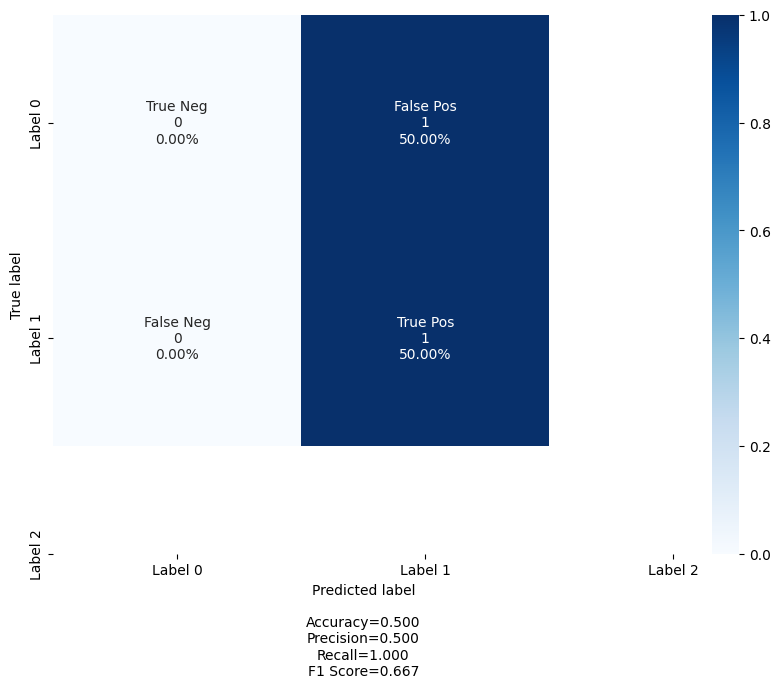

Test Accuracy: 0.50000


In [44]:
lr=0.01
p,e=50,301
acc_gcn, embed_gcn, out_gcn, loss_gcn, valloss_gcn=gcn_function(data_new, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(6.6437, grad_fn=<NllLossBackward0>)  Val loss: tensor(4.1489) Min Val loss: tensor(4.1489) test acc: 0.5
Epoch: 2  Train loss: tensor(4.1489, grad_fn=<NllLossBackward0>)  Val loss: tensor(1.9240) Min Val loss: tensor(1.9240) test acc: 0.5
Epoch: 3  Train loss: tensor(1.9240, grad_fn=<NllLossBackward0>)  Val loss: tensor(1.9360) Min Val loss: tensor(1.9240) test acc: 0.5
Epoch: 4  Train loss: tensor(1.9360, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.7123) Min Val loss: tensor(1.9240) test acc: 0.5
Epoch: 5  Train loss: tensor(2.7123, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.7519) Min Val loss: tensor(1.9240) test acc: 0.5
Epoch: 6  Train loss: tensor(2.7519, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.2810) Min Val loss: tensor(1.9240) test acc: 0.5
Epoch: 7  Train loss: tensor(2.2810, grad_fn=<NllLossBackward0>)  Val loss: tensor(1.5059) Min Val loss: tensor(1.5059) test acc: 0.5
Epoch: 8  Train loss: tensor(1.5059, grad_fn=<NllLossBa

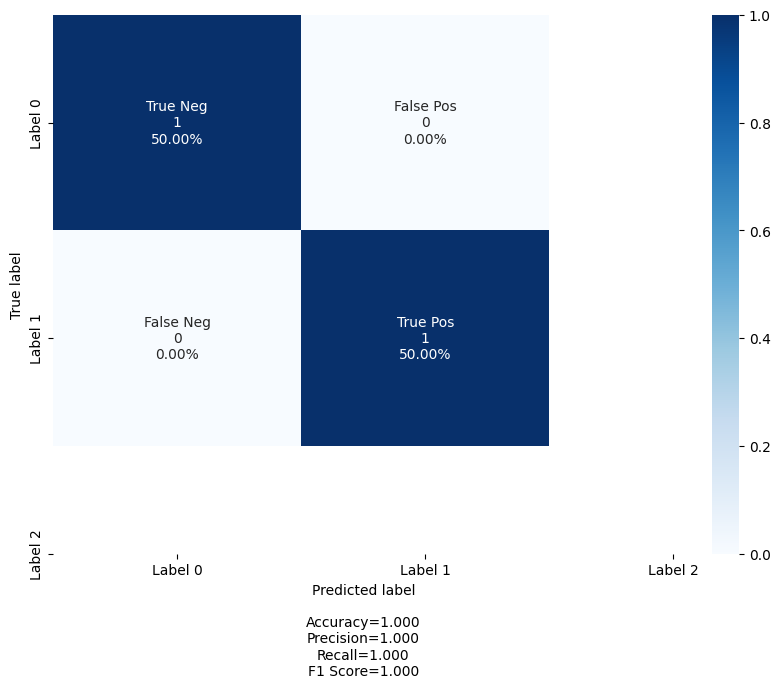

Test Accuracy: 1.00000


In [45]:
lr=0.01
p,e=50,301
acc_gcnpos, embed_gcnpos, out_gcnpos, loss_gcnpos, valloss_gcnpos=gcn_function(data_pos, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(2.5185, grad_fn=<NllLossBackward0>)  Val loss: tensor(1.8002) Min Val loss: tensor(1.8002) test acc: 0.0
Epoch: 2  Train loss: tensor(1.8002, grad_fn=<NllLossBackward0>)  Val loss: tensor(1.1831) Min Val loss: tensor(1.1831) test acc: 0.0
Epoch: 3  Train loss: tensor(1.1831, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.7082) Min Val loss: tensor(0.7082) test acc: 0.0
Epoch: 4  Train loss: tensor(0.7082, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.3921) Min Val loss: tensor(0.3921) test acc: 1.0
Epoch: 5  Train loss: tensor(0.3921, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2089) Min Val loss: tensor(0.2089) test acc: 1.0
Epoch: 6  Train loss: tensor(0.2089, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.1122) Min Val loss: tensor(0.1122) test acc: 1.0
Epoch: 7  Train loss: tensor(0.1122, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0625) Min Val loss: tensor(0.0625) test acc: 1.0
Epoch: 8  Train loss: tensor(0.0625, grad_fn=<NllLossBa

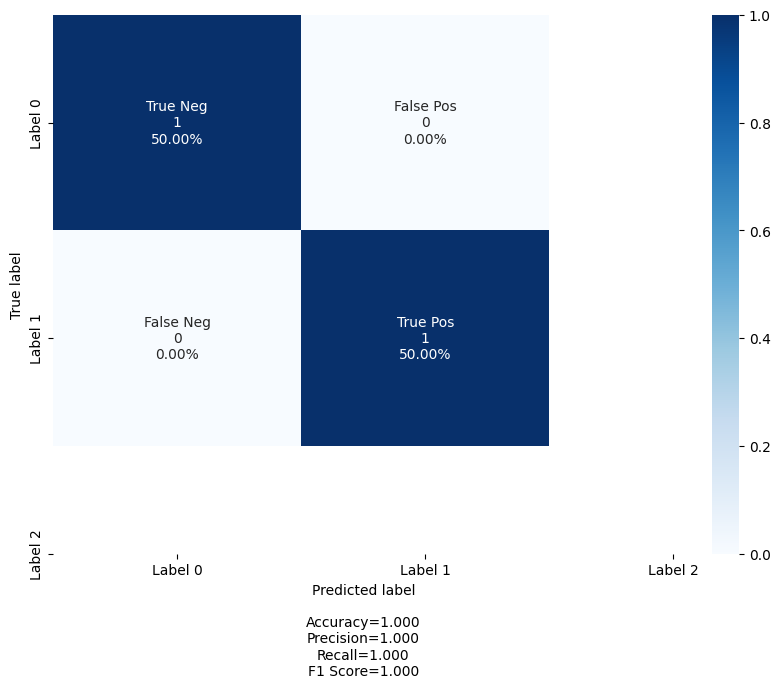

Test Accuracy: 1.00000


In [46]:
lr=0.01
p,e=50,301
acc_gcnlap, embed_gcnlap, out_gcnlap, loss_gcnlap, valloss_gcnlap=gcnlap_function(data_new, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(0.6731, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.6430) Min Val loss: tensor(0.6430) test acc: 1.0
Epoch: 2  Train loss: tensor(0.6430, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.6133) Min Val loss: tensor(0.6133) test acc: 1.0
Epoch: 3  Train loss: tensor(0.6133, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.5838) Min Val loss: tensor(0.5838) test acc: 1.0
Epoch: 4  Train loss: tensor(0.5838, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.5545) Min Val loss: tensor(0.5545) test acc: 1.0
Epoch: 5  Train loss: tensor(0.5545, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.5253) Min Val loss: tensor(0.5253) test acc: 1.0
Epoch: 6  Train loss: tensor(0.5253, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.4963) Min Val loss: tensor(0.4963) test acc: 1.0
Epoch: 7  Train loss: tensor(0.4963, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.4675) Min Val loss: tensor(0.4675) test acc: 1.0
Epoch: 8  Train loss: tensor(0.4675, grad_fn=<NllLossBa

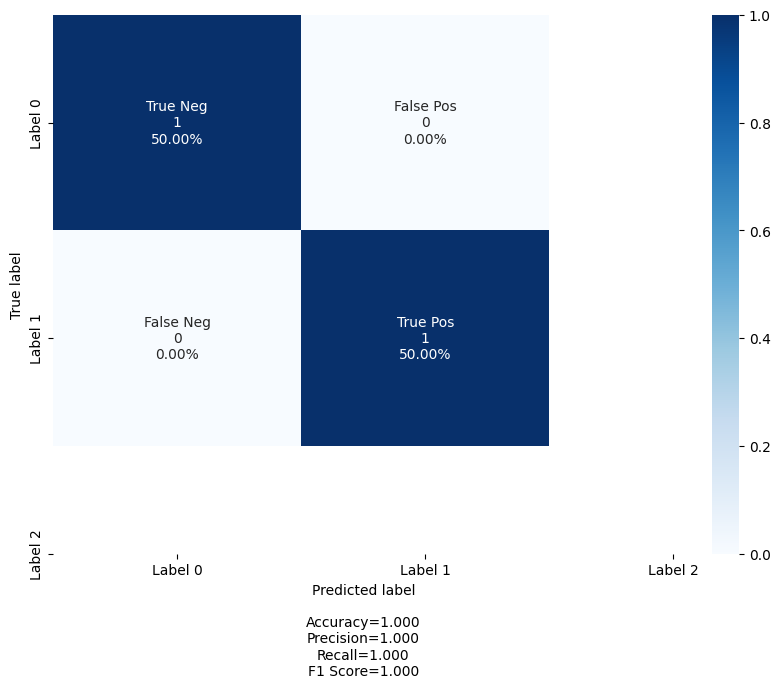

Test Accuracy: 1.00000


In [68]:
lr=0.01
p,e=50,301
acc_gcnlap_std, embed_gcnlap_std, out_gcnlap_std, loss_gcnlap_std, valloss_gcnlap_std=gcnlap_function(data_standard, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(3.7899, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.5945) Min Val loss: tensor(2.5945) test acc: 0.5
Epoch: 2  Train loss: tensor(0.7171, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0105) Min Val loss: tensor(0.0105) test acc: 0.5
Epoch: 3  Train loss: tensor(0.0030, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0001) Min Val loss: tensor(0.0001) test acc: 0.5
Epoch: 4  Train loss: tensor(2.3007e-05, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0004) Min Val loss: tensor(0.0001) test acc: 0.5
Epoch: 5  Train loss: tensor(4.1723e-07, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0009) Min Val loss: tensor(0.0001) test acc: 1.0
Epoch: 6  Train loss: tensor(0., grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0020) Min Val loss: tensor(0.0001) test acc: 1.0
Epoch: 7  Train loss: tensor(0., grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0039) Min Val loss: tensor(0.0001) test acc: 1.0
Epoch: 8  Train loss: tensor(0., grad_fn=<NllLossBackwa

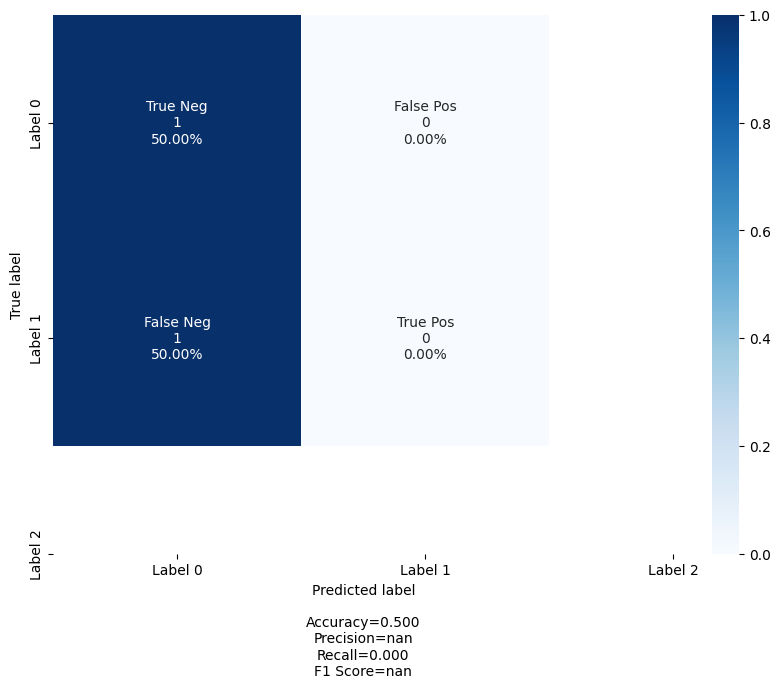

Test Accuracy: 0.50000


In [47]:
lr=0.01
p,e=50,301
acc_gcndiff, embed_gcndiff, out_gcndiff, loss_gcndiff, valloss_gcndiff=gcndiff_function(data_new, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(0.7382, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.3663) Min Val loss: tensor(0.3663) test acc: 0.5
Epoch: 2  Train loss: tensor(0.6247, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.3153) Min Val loss: tensor(0.3153) test acc: 0.5
Epoch: 3  Train loss: tensor(0.5258, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2726) Min Val loss: tensor(0.2726) test acc: 0.5
Epoch: 4  Train loss: tensor(0.4406, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2369) Min Val loss: tensor(0.2369) test acc: 1.0
Epoch: 5  Train loss: tensor(0.3678, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2072) Min Val loss: tensor(0.2072) test acc: 1.0
Epoch: 6  Train loss: tensor(0.3063, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.1824) Min Val loss: tensor(0.1824) test acc: 1.0
Epoch: 7  Train loss: tensor(0.2549, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.1613) Min Val loss: tensor(0.1613) test acc: 1.0
Epoch: 8  Train loss: tensor(0.2124, grad_fn=<NllLossBa

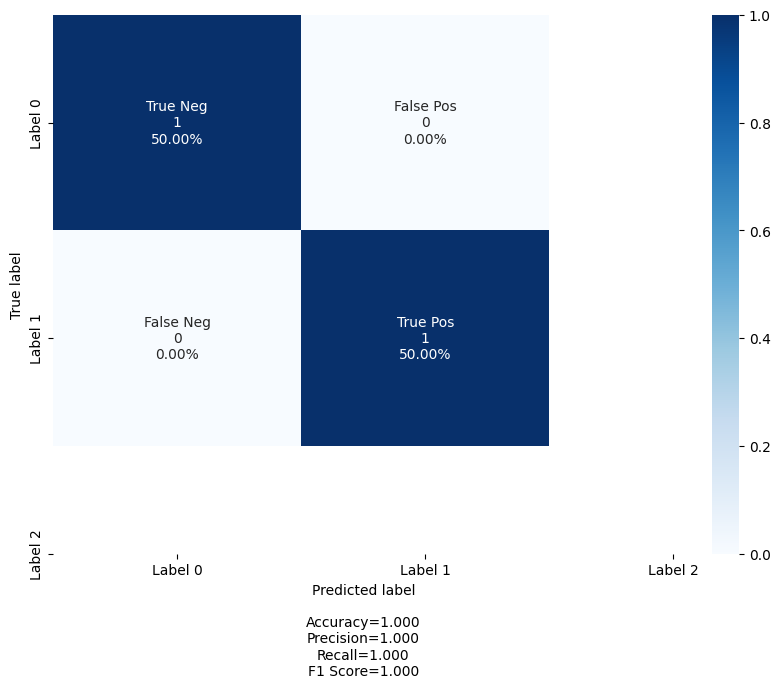

Test Accuracy: 1.00000


In [48]:
lr=0.01
p,e=50,301
acc_gcndiff_std, embed_gcndiff_std, out_gcndiff_std, loss_gcndiff_std, valloss_gcndiff_std=gcndiff_function(data_standard, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(15.8734, grad_fn=<NllLossBackward0>)  Val loss: tensor(15.5216) Min Val loss: tensor(15.5216) test acc: 0.5
Epoch: 2  Train loss: tensor(13.7349, grad_fn=<NllLossBackward0>)  Val loss: tensor(13.0675) Min Val loss: tensor(13.0675) test acc: 0.5
Epoch: 3  Train loss: tensor(11.5838, grad_fn=<NllLossBackward0>)  Val loss: tensor(10.6595) Min Val loss: tensor(10.6595) test acc: 0.5
Epoch: 4  Train loss: tensor(9.4754, grad_fn=<NllLossBackward0>)  Val loss: tensor(8.2784) Min Val loss: tensor(8.2784) test acc: 0.5
Epoch: 5  Train loss: tensor(7.3908, grad_fn=<NllLossBackward0>)  Val loss: tensor(6.1270) Min Val loss: tensor(6.1270) test acc: 0.5
Epoch: 6  Train loss: tensor(5.4910, grad_fn=<NllLossBackward0>)  Val loss: tensor(4.1905) Min Val loss: tensor(4.1905) test acc: 0.5
Epoch: 7  Train loss: tensor(3.7917, grad_fn=<NllLossBackward0>)  Val loss: tensor(2.1982) Min Val loss: tensor(2.1982) test acc: 0.5
Epoch: 8  Train loss: tensor(2.0210, grad_fn=<

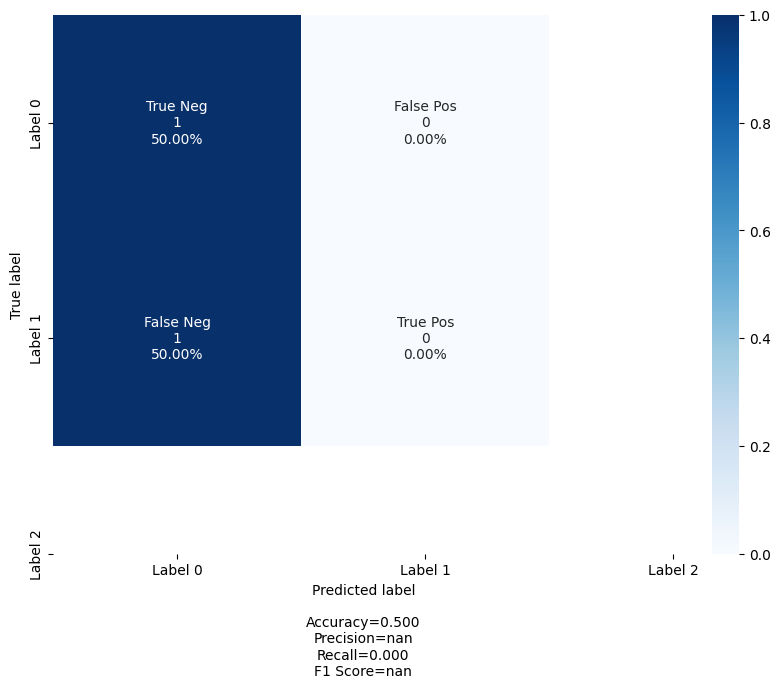

Test Accuracy: 0.50000


In [49]:
lr=0.01
p,e=50,301
acc_gcnnlinear, embed_gcnnlinear, out_gcnnlinear, loss_gcnnlinear, valloss_gcnnlinear=gcnnlinear_function(data_new, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(0.5692, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.4069) Min Val loss: tensor(0.4069) test acc: 1.0
Epoch: 2  Train loss: tensor(0.5118, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.3711) Min Val loss: tensor(0.3711) test acc: 1.0
Epoch: 3  Train loss: tensor(0.4592, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.3388) Min Val loss: tensor(0.3388) test acc: 1.0
Epoch: 4  Train loss: tensor(0.4108, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.3094) Min Val loss: tensor(0.3094) test acc: 1.0
Epoch: 5  Train loss: tensor(0.3665, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2828) Min Val loss: tensor(0.2828) test acc: 1.0
Epoch: 6  Train loss: tensor(0.3264, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2589) Min Val loss: tensor(0.2589) test acc: 1.0
Epoch: 7  Train loss: tensor(0.2903, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.2374) Min Val loss: tensor(0.2374) test acc: 1.0
Epoch: 8  Train loss: tensor(0.2579, grad_fn=<NllLossBa

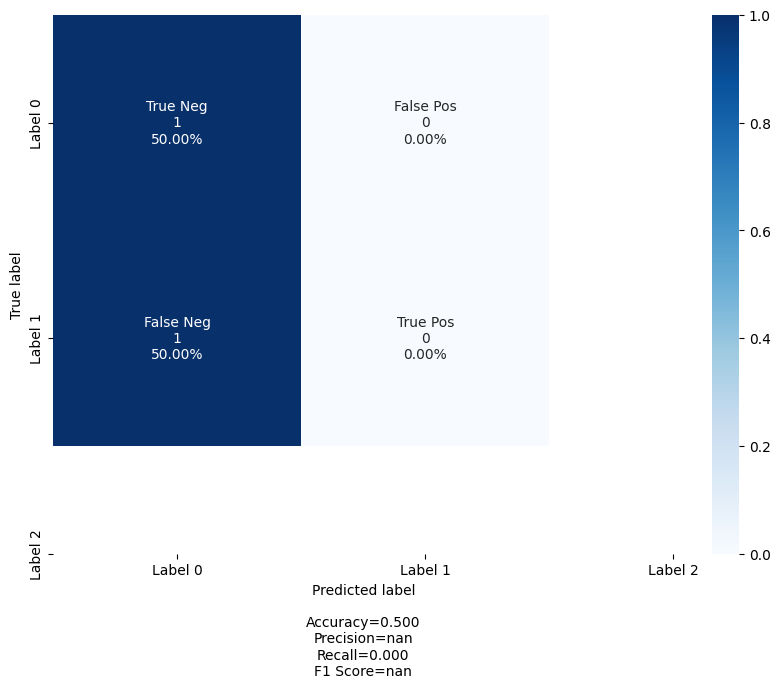

Test Accuracy: 0.50000


In [50]:
lr=0.01
p,e=50,301
acc_gcnnlinear_std, embed_gcnnlinear_std, out_gcnnlinear_std, loss_gcnnlinear_std, valloss_gcnnlinear_std=gcnnlinear_function(data_standard, 1,p,e)

RUN: 0
Epoch: 1  Train loss: tensor(8.7485, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.) Min Val loss: tensor(0.) test acc: 1.0
Epoch: 2  Train loss: tensor(0., grad_fn=<NllLossBackward0>)  Val loss: tensor(0.) Min Val loss: tensor(0.) test acc: 1.0
Epoch: 3  Train loss: tensor(0., grad_fn=<NllLossBackward0>)  Val loss: tensor(0.) Min Val loss: tensor(0.) test acc: 0.5
Epoch: 4  Train loss: tensor(8.9407e-07, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.0486) Min Val loss: tensor(0.) test acc: 0.5
Epoch: 5  Train loss: tensor(1.1106, grad_fn=<NllLossBackward0>)  Val loss: tensor(5.3165e-05) Min Val loss: tensor(0.) test acc: 0.5
Epoch: 6  Train loss: tensor(0.0042, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.) Min Val loss: tensor(0.) test acc: 0.5
Epoch: 7  Train loss: tensor(0., grad_fn=<NllLossBackward0>)  Val loss: tensor(0.) Min Val loss: tensor(0.) test acc: 1.0
Epoch: 8  Train loss: tensor(0., grad_fn=<NllLossBackward0>)  Val loss: tensor(0.) Min Val loss: tensor(0.)

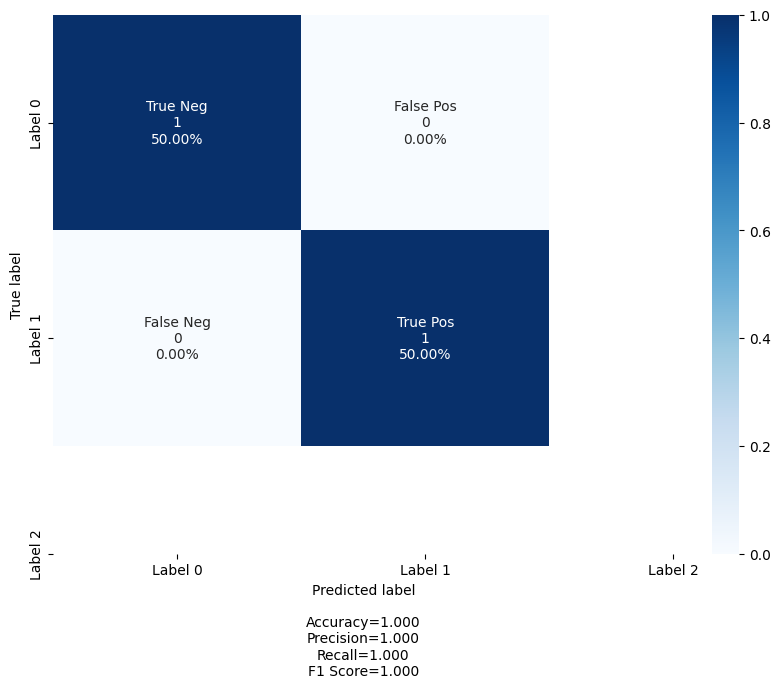

Test Accuracy: 1.00000


In [51]:
lr=0.01
p,e=50,301
acc_rgcn, embed_rgcn, out_rgcn, loss_rgcn, valloss_rgcn=rgcn_net_function(data_new, 1,p,e)

RUN: 0
ori Parameter containing:
tensor([[ 0.5829, -0.1279]], requires_grad=True)
negative weight tensor(0.6706, grad_fn=<SelectBackward0>)
ori Parameter containing:
tensor([[ 0.4859, -0.4139]], requires_grad=True)
negative weight tensor(0.7109, grad_fn=<SelectBackward0>)
ori Parameter containing:
tensor([[ 0.5729, -0.1179]], requires_grad=True)
negative weight tensor(0.6662)
ori Parameter containing:
tensor([[ 0.4759, -0.4039]], requires_grad=True)
negative weight tensor(0.7068)
ori Parameter containing:
tensor([[ 0.5729, -0.1179]], requires_grad=True)
negative weight tensor(0.6662)
ori Parameter containing:
tensor([[ 0.4759, -0.4039]], requires_grad=True)
negative weight tensor(0.7068)
Epoch: 1  Train loss: tensor(52.5072, grad_fn=<NllLossBackward0>)  Val loss: tensor(42.8320) Min Val loss: tensor(42.8320) test acc: 0.0
ori Parameter containing:
tensor([[ 0.5729, -0.1179]], requires_grad=True)
negative weight tensor(0.6662, grad_fn=<SelectBackward0>)
ori Parameter containing:
tensor(

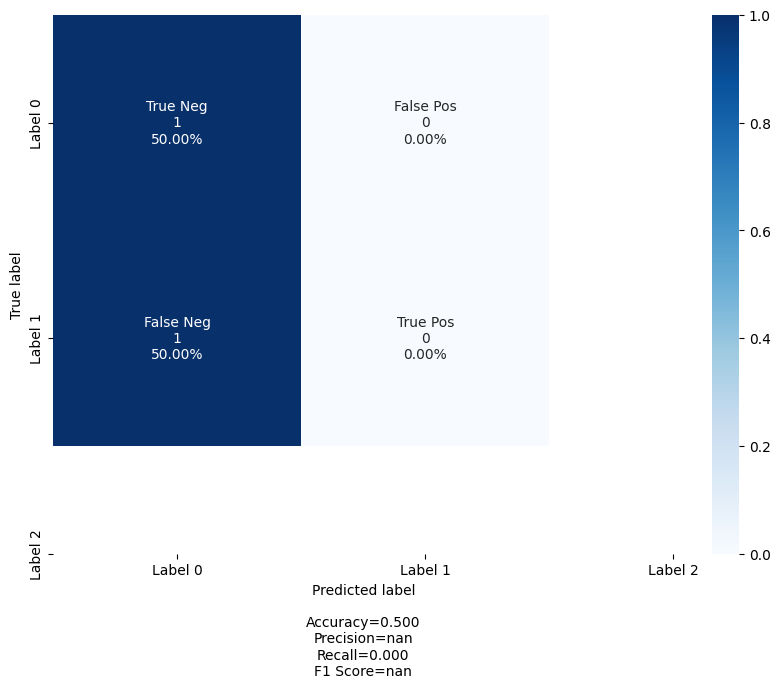

Test Accuracy: 0.50000


In [52]:
lr=0.01
p,e=50,301
acc_gcnrepel, embed_gcnrepel, out_gcnrepel, loss_gcnrepel, valloss_gcnrepel, c1, c2 =gcndiff_repel_function(data_new, 1,p,e)

RUN: 0
ori Parameter containing:
tensor([[-0.3682, -0.8809]], requires_grad=True)
negative weight tensor(0.6254, grad_fn=<SelectBackward0>)
ori Parameter containing:
tensor([[-0.4115, -0.2913]], requires_grad=True)
negative weight tensor(0.4700, grad_fn=<SelectBackward0>)
ori Parameter containing:
tensor([[-0.3782, -0.8709]], requires_grad=True)
negative weight tensor(0.6207)
ori Parameter containing:
tensor([[-0.4015, -0.3013]], requires_grad=True)
negative weight tensor(0.4750)
ori Parameter containing:
tensor([[-0.3782, -0.8709]], requires_grad=True)
negative weight tensor(0.6207)
ori Parameter containing:
tensor([[-0.4015, -0.3013]], requires_grad=True)
negative weight tensor(0.4750)
Epoch: 1  Train loss: tensor(0.6348, grad_fn=<NllLossBackward0>)  Val loss: tensor(0.4464) Min Val loss: tensor(0.4464) test acc: 0.5
ori Parameter containing:
tensor([[-0.3782, -0.8709]], requires_grad=True)
negative weight tensor(0.6207, grad_fn=<SelectBackward0>)
ori Parameter containing:
tensor([[-

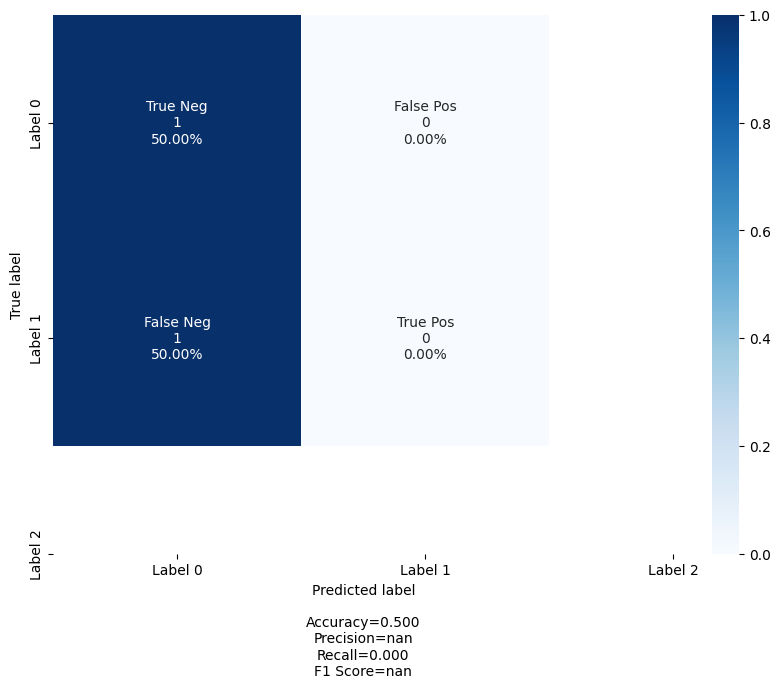

Test Accuracy: 0.50000


In [53]:
lr=0.01
p,e=50,301
acc_gcnrepel_std, embed_gcnrepel_std, out_gcnrepel_std, loss_gcnrepel_std, valloss_gcnrepel_std, c1_std, c2_std =gcndiff_repel_function(data_standard, 1,p,e)

# ANIMATION

In [54]:
print('train nodes:', train_nodes) #circle nodes
print('val nodes:', val_nodes) #triangle nodes
print('test nodes:', test_nodes) #square nodes

train nodes: [2, 3]
val nodes: [0, 5]
test nodes: [1, 4]


{0: [53.196564638325945, 32.22304556051513], 1: [89.39008442672643, 11.204718710725238], 2: [71.40245422698906, 11.203346922041447], 3: [46.887358171694395, 46.618729659086334], 4: [92.18115911950504, 3.8721133292303413], 5: [80.28865278336868, 72.78044485944633]}


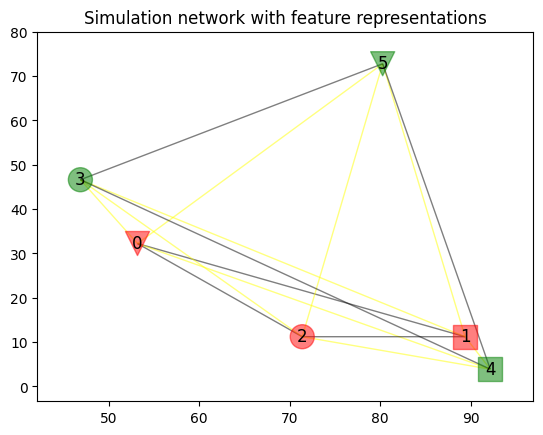

In [55]:
feature_representations = {node: [K.nodes[node]['feat1'], K.nodes[node]['feat2']] for node in K.nodes()}
print(feature_representations)
fig, ax = plt.subplots()
# plt.figure(dpi=100)
# Extract the feature representations
# Plot the embeddings
nx.draw_networkx_edges(K,pos= feature_representations, edge_color=edge_color, alpha=0.5, ax=ax) # draw edges
nx.draw_networkx_labels(K,pos= feature_representations, ax=ax) # draw node labels
for shape in set(node_shapes):
    # the nodes with the desired shapes
    node_list = [node for node in K.nodes() if K.nodes[node]['shape'] == shape]
    nx.draw_networkx_nodes(K,pos= feature_representations,
                          nodelist = node_list,
                          node_color= [K.nodes[node]['color'] for node in node_list],
                          node_shape = shape,
                          alpha=0.5,  node_size=300, ax=ax)
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.title('Simulation network with feature representations')
plt.show()

## Unnormalized features

In [56]:
anim_plot('gcn', out_gcn, acc_gcn, K)

In [57]:
anim_plot('pos-gcn', out_gcnpos, acc_gcnpos, K)

In [58]:
anim_plot('rgcn', out_rgcn, acc_rgcn, K)

In [71]:
anim_plot('lap-gcn', out_gcnlap, acc_gcnlap, K)

In [59]:
anim_plot('diff-gcn', out_gcndiff, acc_gcndiff, K)

In [61]:
anim_plot('nlinear-gcn', out_gcnnlinear, acc_gcnnlinear, K)

In [63]:
anim_plot('diff-gcn-repel', out_gcnrepel, acc_gcnrepel, K)

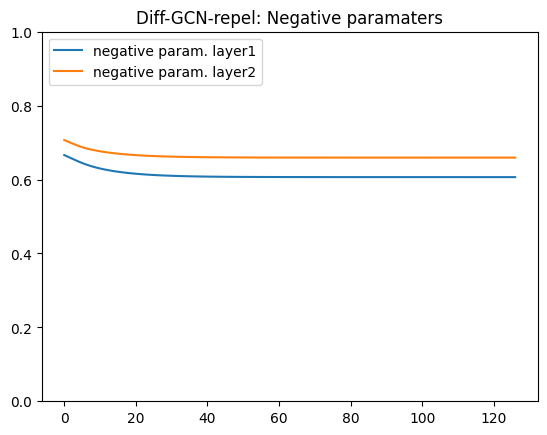

In [76]:
plt.plot(c1[0], label='negative param. layer1')
plt.plot(c2[0], label='negative param. layer2')
plt.legend(loc='upper left')
plt.title('Diff-GCN-repel: Negative paramaters')
plt.ylim([0,1])
plt.show()

## z-score features

In [72]:
anim_plot('lap-gcn-std', out_gcnlap_std, acc_gcnlap_std, K)

In [60]:
anim_plot('diff-gcn-std', out_gcndiff_std, acc_gcndiff_std, K)

In [62]:
anim_plot('nlinear-gcn-std', out_gcnnlinear_std, acc_gcnnlinear_std, K)

In [67]:
anim_plot('diff-gcn-repel-std', out_gcnrepel_std, acc_gcnrepel_std, K)

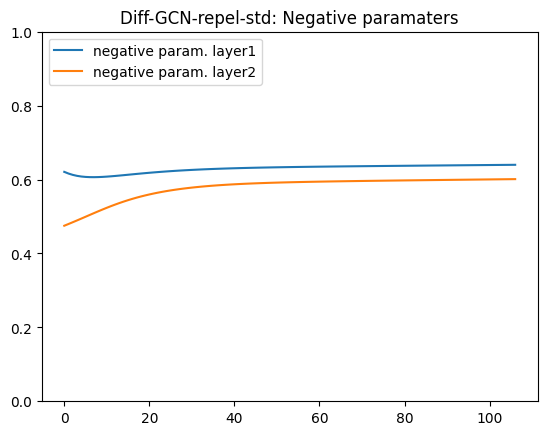

In [75]:
plt.plot(c1_std[0], label='negative param. layer1')
plt.plot(c2_std[0], label='negative param. layer2')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.title('Diff-GCN-repel-std: Negative paramaters')
plt.show()